In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
import scanpy as sc
sc.settings.verbosity = 2
import anndata
from readcount_tools import plot_mean_vs

#import plotting constants
from readcount_tools import PAPER_CONTEXT, PAGEWIDTH_IN, SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE,LINEWIDTH,POINTSIZE,TICKLENGTH,LEGEND_FONTSIZE,SPINEWIDTH,LETTER_LOC_X,LETTER_LOC_Y

In [2]:
exp2run = {'CELseq2A':'A',
 'CELseq2B':'B',
 'DropSeqA':'A',
 'DropSeqB':'B',
 'MARSseqA':'A',
 'MARSseqB':'B',
 'SCRBseqA':'A',
 'SCRBseqB':'B',
 'Smartseq3_Fibroblast':'A',
 'Smartseq3_Fibroblast_PE':'A'}
exp2prot = {'CELseq2A':'CEL-seq2',
 'CELseq2B':'CEL-seq2',
 'DropSeqA':'Drop-seq',
 'DropSeqB':'Drop-seq',
 'MARSseqA':'MARS-seq',
 'MARSseqB':'MARS-seq',
 'SCRBseqA':'SCRB-seq',
 'SCRBseqB':'SCRB-seq',
 'Smartseq3_Fibroblast':'Smart-seq3 SE',
 'Smartseq3_Fibroblast_PE':'Smart-seq3 PE'}

In [3]:
### Use only mouse datasets
experiments = ['CELseq2A', 'CELseq2B',
               'DropSeqA', 'DropSeqB', 
               'MARSseqA', 'MARSseqB', 
               'SCRBseqA', 'SCRBseqB', 
               'Smartseq3_Fibroblast',
               'Smartseq3_Fibroblast_PE']

basepath = 'data/reads_per_umi_tables/'


bottom_criterion = 'ff_reads'
n_bottom = 7000

adatas_by_exp = []
bottom_genes = []
genes_by_exp = []
n_genes = []

for exp in experiments:
    fullpath = (f'{basepath}ad_readcounts_umicounts_hd1_{exp}')
    #fullpath = (f'{path}00_preload_ziegenhain_ad_readcounts_umicounts_{hd}_{exp}')
    ad = anndata.read_h5ad(fullpath)
    
    #ad.var.set_index('genes',inplace=True)
    ad.obs['experiment'] = ad.uns['experiment']
    ad.obs['index'] = ad.obs['experiment'] + '_' + ad.obs['cells'] 
    ad.obs.set_index('index',inplace=True)
    
    ad.obs['protocol']=[exp2prot[exp] for exp in ad.obs.experiment]
    ad.obs['run']=[exp2run[exp] for exp in ad.obs.experiment]
    ad.obs['plotlabel'] = [p+' '+r for p,r in zip(ad.obs['protocol'],ad.obs['run'])]
        
    ad.uns['experiment']=exp
    ad.uns['protocol']=exp2prot[exp]
    ad.uns['run']=exp2run[exp]
    ad.uns['plotlabel']=ad.uns['protocol']+' '+ad.uns['run']
    #remove .. A from SE and PE runs because we only have one run there
    ad.uns['plotlabel'] = ad.uns['plotlabel'].replace('E A','E') 
    
    sc.pp.filter_genes(ad,min_counts=1)
    sc.pp.filter_cells(ad,min_counts=1)
    
    #compute readcount statistics within each exp
    variances_reads = np.var(ad.layers['reads'].A,axis=0)
    means_reads = np.squeeze(np.mean(ad.layers['reads'].A,axis=0))
    ffs_reads = variances_reads/means_reads    
    ad.var['var_reads'] = variances_reads
    ad.var['ff_reads'] = ffs_reads
    ad.var['mean_reads'] = means_reads
    
    bottom_criterion_cutoff = np.sort(ad.var[bottom_criterion])[n_bottom]
    ad.uns['bottom_criterion_cutoff']=bottom_criterion_cutoff
    ad.var['bottom_cloud_idx'] = ad.var[bottom_criterion] <= bottom_criterion_cutoff
    bottom_genes.append(ad.var.index[ad.var['bottom_cloud_idx']])

    genes_by_exp.append(ad.var.index)    
    adatas_by_exp.append(ad)
    
    print(ad.uns['protocol'],ad.uns['run'], ad.shape,sep='\t')
    n_genes.append(ad.shape[1])


CEL-seq2	A	(34, 23555)
CEL-seq2	B	(37, 25479)
Drop-seq	A	(42, 23530)
Drop-seq	B	(34, 22104)
MARS-seq	A	(29, 20307)
MARS-seq	B	(36, 21150)
SCRB-seq	A	(39, 24054)
SCRB-seq	B	(45, 24281)
Smart-seq3 SE	A	(145, 23161)
Smart-seq3 PE	A	(319, 25427)


In [4]:
adatas_by_exp_A=[ad for ad in adatas_by_exp if ad.uns['run']=='A']

## Analysis

### Pairwise intersection fraction matrix

In [5]:
def compute_intersections(bottom_genes,return_raw=False):
    intersection_fraction = np.zeros((len(bottom_genes),len(bottom_genes)))
    for i_a,bottom_a in enumerate(bottom_genes):
        for i_b,bottom_b in enumerate(bottom_genes):

            if return_raw:
                intersection_fraction[i_a,i_b]=len(np.intersect1d(bottom_a,bottom_b))
            else:
                intersection_fraction[i_a,i_b]=len(np.intersect1d(bottom_a,bottom_b))/len(bottom_a)

    np.fill_diagonal(intersection_fraction,val=np.nan)
    
    return intersection_fraction

In [6]:
n_shared_genes = compute_intersections(genes_by_exp,return_raw=True)

In [7]:
intersection_matrix_raw = compute_intersections(bottom_genes,return_raw=True)
intersection_matrix = compute_intersections(bottom_genes)

In [8]:
def compute_chance_intersections(n_genes_shared_between_runs,n_genes_per_run,n_subset=3000):
    n_genes_chance_intersection = np.zeros((len(n_genes_per_run),len(n_genes_per_run)))
    for i_a,n_a in enumerate(n_genes):
        for i_b,n_b in enumerate(n_genes):
            
            n_shared = n_genes_shared_between_runs[i_a,i_b]
            n_genes_chance_intersection[i_a,i_b] = (n_subset**2 * n_shared) / (n_a * n_b)

    np.fill_diagonal(n_genes_chance_intersection,val=np.nan)
    
    return n_genes_chance_intersection

In [9]:
chance_intersections = compute_chance_intersections(n_genes_shared_between_runs=n_shared_genes,n_genes_per_run=n_genes,n_subset=n_bottom)

### Paper version: Fig S3B

In [10]:
def plot_intersection_matrix(intersection_fraction,runs,
                             ax=None,vmin=None,vmax=None,
                             print_floats=True,print_thousands=False,print_pct=False,
                             fontsize=12):

    if ax:
        plt.sca(ax)
    
    plt.imshow(intersection_fraction,vmin=vmin,vmax=vmax)    
    plt.xticks(ticks=np.arange(len(runs)),labels=runs,rotation=90)
    plt.yticks(ticks=np.arange(len(runs)),labels=runs)

    for row in range(len(runs)):
        for clm in range(len(runs)):
            if row<=clm:
                continue
            if print_floats:
                plt.text(clm,row,f'{intersection_fraction[row,clm]:.1f}',ha='center',va='center',fontsize=fontsize,fontweight='bold')
            elif print_thousands:
                number = np.round(intersection_fraction[row,clm]/1000,decimals=1)
                plt.text(clm,row,f'{number}k',ha='center',va='center',fontsize=fontsize,fontweight='bold')
            elif print_pct:
                pct = int(np.round(intersection_fraction[row,clm]*100))
                plt.text(clm,row,f'{pct}%',ha='center',va='center',fontsize=fontsize,fontweight='bold')
            else:
                plt.text(clm,row,'%u'%int(intersection_fraction[row,clm]),ha='center',va='center',fontsize=fontsize,fontweight='bold')

tcmalloc: large alloc 4438712320 bytes == 0x17c0c000 @ 
tcmalloc: large alloc 4438712320 bytes == 0x120522000 @ 
tcmalloc: large alloc 4438712320 bytes == 0x237f4c000 @ 
tcmalloc: large alloc 4438712320 bytes == 0x340862000 @ 
tcmalloc: large alloc 4438712320 bytes == 0x449978000 @ 
tcmalloc: large alloc 4429291520 bytes == 0x17c0c000 @ 
tcmalloc: large alloc 4429291520 bytes == 0x449978000 @ 
tcmalloc: large alloc 4429291520 bytes == 0x11fc26000 @ 
tcmalloc: large alloc 4429291520 bytes == 0x237f4c000 @ 
tcmalloc: large alloc 4429291520 bytes == 0x33ff66000 @ 
tcmalloc: large alloc 4628766720 bytes == 0x237f4c000 @ 
tcmalloc: large alloc 4628766720 bytes == 0x17c0c000 @ 
tcmalloc: large alloc 4628766720 bytes == 0x449978000 @ 
tcmalloc: large alloc 5172264960 bytes == 0x17c0c000 @ 


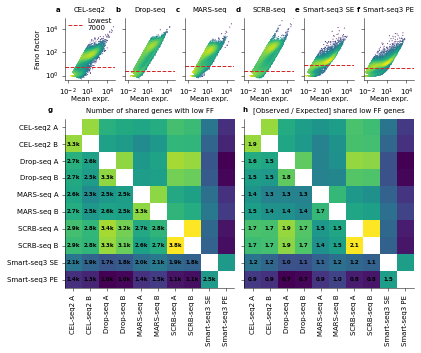

In [11]:
ncols = 6
figheight_in = PAGEWIDTH_IN/ncols * 5.4

path='figures/S_ziegenhain_overlap.pdf'

with mpl.rc_context(PAPER_CONTEXT):
    
    gridrows = 24
    
    fig = plt.figure(figsize=(PAGEWIDTH_IN,figheight_in))
    axes_toprow = np.array([plt.subplot2grid(shape=(gridrows,ncols),   loc=(0, col), colspan=1,rowspan=5) for col in range(6)])
    ax_left = plt.subplot2grid(    shape=(gridrows,ncols),   loc=(5, 0),    colspan=3,rowspan=19)
    ax_right = plt.subplot2grid(   shape=(gridrows,ncols),   loc=(5, 3),    colspan=3,rowspan=19)
    axes_all = list(axes_toprow) + [ax_left] + [ax_right]


    
    plot_mean_vs(adatas_by_exp_A,axes=axes_toprow,
                 ykey='ff_reads',xkey='mean_reads',s=POINTSIZE,)
    
    
    min_y = min([min(ad.var['ff_reads']) for ad in adatas_by_exp_A])
    max_y = max([max(ad.var['ff_reads']) for ad in adatas_by_exp_A])
    min_x = min([min(ad.var['mean_reads']) for ad in adatas_by_exp_A])
    max_x = max([max(ad.var['mean_reads']) for ad in adatas_by_exp_A])
    
    for ad,ax in zip(adatas_by_exp_A,axes_toprow):
        ax.hlines(ad.uns['bottom_criterion_cutoff'],
                  xmin=min_x,
                  xmax=max_x,
                  lw=LINEWIDTH,
                  color='tab:red',
                  linestyles='--',
                  label=f'Lowest\n{n_bottom}')
    axes_toprow[0].legend(loc=(0,0.75),frameon=False)
    axes_toprow[0].set_ylabel('Fano factor')
    
    [ax.set_xlim(min_x,max_x) for ax in axes_toprow]
    [ax.set_ylim(min_y,max_y) for ax in axes_toprow]
    [ax.set_yticks([10**0,10**2,10**4]) for ax in axes_toprow]
    [ax.set_yticklabels([]) for ax in axes_toprow[1:]]
    [ax.set_xticks([10**-2,10**1,10**4]) for ax in axes_toprow]
    [ax.set_xlabel('Mean expr.',labelpad=-2) for ax in axes_toprow]
    
    plt.minorticks_off()
    run_labels = [ad.uns['plotlabel'] for ad in adatas_by_exp]
    
    ax_left.set_title('Number of shared genes with low FF')
    plot_intersection_matrix(intersection_matrix_raw,run_labels,print_floats=False,print_thousands=True,ax=ax_left,fontsize=LEGEND_FONTSIZE)
    
    plot_intersection_matrix(intersection_matrix_raw/chance_intersections,run_labels,ax=ax_right,fontsize=LEGEND_FONTSIZE)
    ax_right.set_yticklabels([])    
    ax_right.set_title('[Observed / Expected] shared low FF genes')

    letters=['a','b','c','d','e','f',
            'g','h']
    x_corrections=[0.12]*5 + [0.15] + [0.2, 0.29]
    y_corrections=[0.15]*6 + [0.09]*2
    for i,(ax,letter,letter_x_correction,letter_y_correction) in enumerate(zip(axes_all,letters,x_corrections,y_corrections)):        
        if i<6:
            sns.despine(ax=ax)
            axes=['bottom','left']
        else:
            axes=['bottom','left','top','right']            
        for axis in axes:
            ax.spines[axis].set_linewidth(SPINEWIDTH)
        ax.text(LETTER_LOC_X+letter_x_correction,LETTER_LOC_Y+letter_y_correction,letter,transform=ax.transAxes,fontweight='bold')
        
    fig.savefig(path, dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)